# Reproducing the multi-label commit classification method using transfer learning described in the [article](https://www.researchgate.net/profile/Mohamed-Wiem-Mkaouer-2/publication/348228961_Multi-label_Classification_of_Commit_Messages_using_Transfer_Learning/links/61eacfc2c5e3103375ae596d/Multi-label-Classification-of-Commit-Messages-using-Transfer-Learning.pdf) 

In [5]:
import transformers

from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import numpy as np
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading dataset

Using the given dataset from [here]( https://zenodo.org/record/3948448#.Y0kwAOxBw-Q)

In [6]:
df = pd.read_csv('/kaggle/input/commit-labeling/train_2K.csv')
df.head()

,Unnamed: 0,text,Corrective,Adaptive,Perfective
0,0,netfilter: xt_log: fix mark logging for ip...,1,0,0
1,1,[patch] inode-diet: eliminate i_blksize fr...,1,0,0
2,2,tensor roll op implementation (#14953) ...,1,1,0
3,3,improve video updates from sheet,0,0,1
4,4,[spark-9372] [sql] filter nulls in join ke...,0,0,1


## Data analyzing

In [7]:
df['count'] = df['text'].apply(lambda x: len(x.split()))

In [8]:
df.head()

,Unnamed: 0,text,Corrective,Adaptive,Perfective,count
0,0,netfilter: xt_log: fix mark logging for ip...,1,0,0,52
1,1,[patch] inode-diet: eliminate i_blksize fr...,1,0,0,50
2,2,tensor roll op implementation (#14953) ...,1,1,0,53
3,3,improve video updates from sheet,0,0,1,5
4,4,[spark-9372] [sql] filter nulls in join ke...,0,0,1,56


## Counting the number of words in commit messages

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



<Figure size 800x800 with 0 Axes>

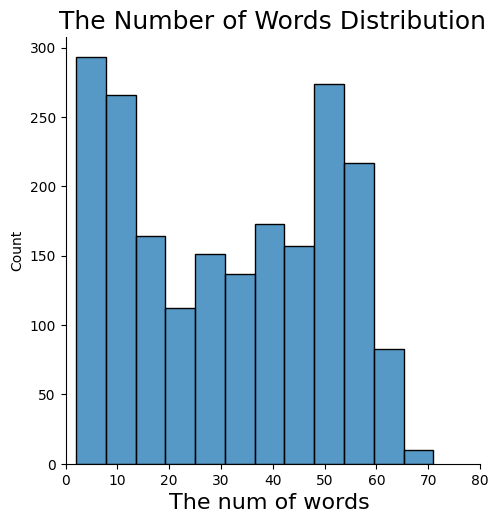

In [9]:
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 80)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

## Distribution by commit category

In [10]:
corr_sum = sum([int(val) for val in df['Corrective']])
corr_sum

758

In [11]:
perf_sum = sum([int(val) for val in df['Perfective']])
perf_sum

942

In [12]:
adapt_sum = sum([int(val) for val in df['Adaptive']])
adapt_sum

662

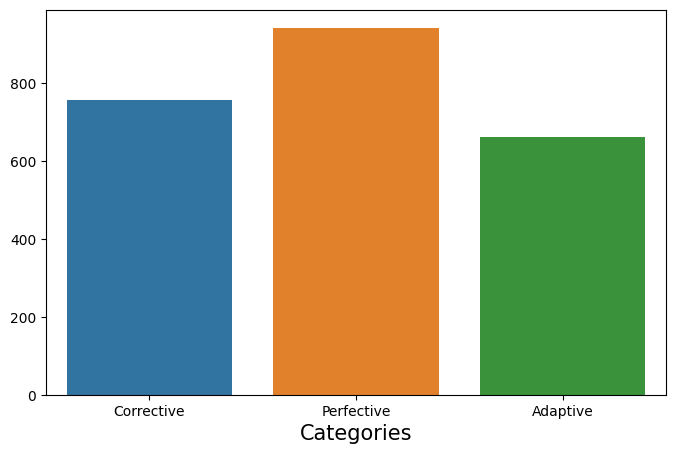

In [13]:
fig = plt.figure(figsize = (8, 5))

x = ['Corrective', 'Perfective', 'Adaptive']
y = [corr_sum, perf_sum, adapt_sum]

plt.xlabel('Categories', size = 15)

sns.barplot(x=x, y=y);
plt.show()

Extracting commit messages and corresponding labels 

In [14]:
data_texts = df["text"].tolist()
data_labels = df[df.columns[2:5]].values

## Data split

Splitting of the data to *train* and *validation* groups using ratio 85%-15% proposed in the article

In [15]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.15, random_state=0)

# Model definition

In [16]:
MODEL_NAME = 'distilbert-base-uncased'

### Encode with DistilBertTokenizer

In [17]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)

val_encodings = tokenizer(val_texts, truncation=True, padding=True)

## Turning labels and encodings into tf.Dataset object

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    list(train_labels)
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    list(val_labels)
))

# Fine-tuning

Here the custom model is used in order to add a dense layer with sigmoid activation to the end of the model

In [19]:
class MyModel(tf.keras.Model):
    def __init__(self, num_labels):
        super(MyModel, self).__init__()
        self.distilbert = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
        self.fc = tf.keras.layers.Dense(num_labels, activation='sigmoid')

    def call(self, inputs, training=False):
        outputs = self.distilbert(inputs, training=training)
        pooled_output = outputs['logits']
        output = self.fc(pooled_output)
        return output


After several tests with different numbers of epochs, it was found out that the optimal number for teaching the model is 4 epochs (exactly the same parameter that was used in the article)

In [ ]:
model = MyModel(3)

BATCH_SIZE = 8
N_EPOCHS = 4

optimizerr = tf.keras.optimizers.Adam(learning_rate=2e-5)
losss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optimizerr,
              loss=losss,
              metrics=['accuracy'])

history = model.fit(train_dataset.batch(BATCH_SIZE),
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE
         )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/4
217/217 [==============================] - 73s 206ms/step - loss: 0.5074 - accuracy: 0.6563
Epoch 2/4
128/217 [================>.............] - ETA: 8s - loss: 0.3761 - accuracy: 0.8477

## Model saving

In [ ]:
model.save('my_model')

In [ ]:
saved_model = tf.keras.models.load_model('my_model')

# Result evaluation

In [ ]:
history_eval = model.evaluate(val_dataset.batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

In [ ]:
loss_list = history.history['loss']

plt.plot(list(range(1, len(loss_list) + 1)), loss_list)
plt.xlabel('epochs', size = 15)
plt.ylabel('loss')
plt.xticks([1, 2, 3, 4])

The graph shows what error the model produces on test data during training at each step of four epochs

# Result validating

In [ ]:
def predict_proba(text_list):
    encodings = tokenizer(text_list, truncation=True, padding=True)
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings))) 
    return np.rint(model.predict(dataset)).astype(int)

In [ ]:
result = predict_proba(val_texts)

In [ ]:
result[:20]

In [ ]:
val_labels[:20]

In [ ]:
incorrect_elems = 0
for i in range(len(result)):
    for j in range(3):
        if result[i][j] != val_labels[i][j]:
            incorrect_elems += 1

Calculating ***hamming loss*** - percentage of incorrect labels

In [ ]:
hamming_loss = (incorrect_elems / (len(result) * 3))
hamming_loss

# Model testing on NNGen datasets 

**Test dataset**

In [ ]:
test_file = open('/kaggle/input/nngen-test/cleaned.test.msg', 'r').readlines()
valid_file = open('/kaggle/input/nngen-test/cleaned.valid.msg', 'r').readlines()

In [ ]:
test_texts = [elem.lower() for elem in test_file]
valid_texts = [elem.lower() for elem in valid_file]

In [ ]:
res_test = predict_proba(test_texts)

In [ ]:
corr_sum_test = sum(list(elem[0] for elem in res_test))
corr_sum_test

In [ ]:
perf_sum_test = sum(list(elem[1] for elem in res_test))
perf_sum_test

In [ ]:
adapt_sum_test = sum(list(elem[2] for elem in res_test))
adapt_sum_test

In [ ]:
fig = plt.figure(figsize = (8, 5))

x = ['Corrective', 'Perfective', 'Adaptive']
y = [corr_sum_test, perf_sum_test, adapt_sum_test]

plt.xlabel('Categories', size = 15)

sns.barplot(x=x, y=y);
plt.show()

**Validate dataset**

In [ ]:
res_valid = predict_proba(valid_texts)

In [ ]:
corr_sum_valid = sum(list(elem[0] for elem in res_test))
corr_sum_valid


In [ ]:
perf_sum_valid = sum(list(elem[1] for elem in res_test))
perf_sum_valid

In [ ]:
adapt_sum_valid = sum(list(elem[2] for elem in res_test))
adapt_sum_valid

In [ ]:
fig = plt.figure(figsize = (8, 5))

x = ['Corrective', 'Perfective', 'Adaptive']
y = [corr_sum_valid, perf_sum_valid, adapt_sum_valid]

plt.xlabel('Categories', size = 15)

sns.barplot(x=x, y=y);
plt.show()

Summation: the model showed the same result on the testing and validation sets